# __SpringBoard Capstone Project 1: Machine Learning__
## __(Cervical Cancer Dataset)__

__Written by: Sofy Weisenberg__<br>
__Date: 02/18/20__


__Step 1: Importing the Dataset and Data Preparation__<br>
Import the original dataset and perform data wrangling steps to prepare data for analysis (for details on these steps, see: https://github.com/s-weisenberg/Springboard/blob/master/Capstone_Project_1/Capstone1_Data_Wrangling.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df = df.replace('?', np.nan)
for column, values in df.iteritems():
        df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1)
df = df.fillna(df.median())
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


__Step 2: Splitting the Data__<br>
The dataframe needs to be split into the feature and target data and some data must be set aside for model validation.

In [2]:
from sklearn.model_selection import train_test_split

# split the data into features and target 
X = df.drop(['Biopsy'],axis=1)
y = df['Biopsy']

random_state = np.random.RandomState(0)

# perform stratified test-train split to hold off 25% of data for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)

__Step 3: Trying out various ML models__<br>
As a start, a few traditional ML models will be fit to the data. Later, a deep learning model will be implemented for comparison.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

logistic = LogisticRegression(solver='liblinear')

# define hyperparameter options
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
#solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight)
                  #solver=solver

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=logistic,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = 5)

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.4s finished
C:\Users\Niv\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score (F1): 0.6754
Best Params:  {'C': 1, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l1'}


In [24]:
from sklearn.metrics import average_precision_score

clf = LogisticRegression(C=1, class_weight={1: 0.7, 0: 0.3}, penalty='l1', random_state=random_state, solver='liblinear')
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))


Average precision-recall score: 0.61


In [19]:
metrics.classification_report(y_test, y_pred, labels=[0,1])

'              precision    recall  f1-score   support\n\n           0       0.99      0.97      0.98       201\n           1       0.65      0.93      0.76        14\n\n    accuracy                           0.96       215\n   macro avg       0.82      0.95      0.87       215\nweighted avg       0.97      0.96      0.97       215\n'

Text(0, 0.5, 'Precision')

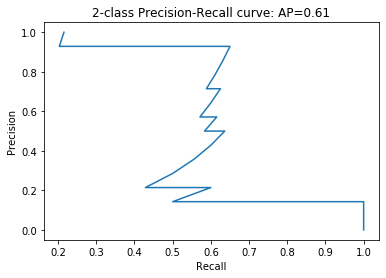

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(precision, recall)
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')